In [1]:
!pip install pandas matplotlib seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


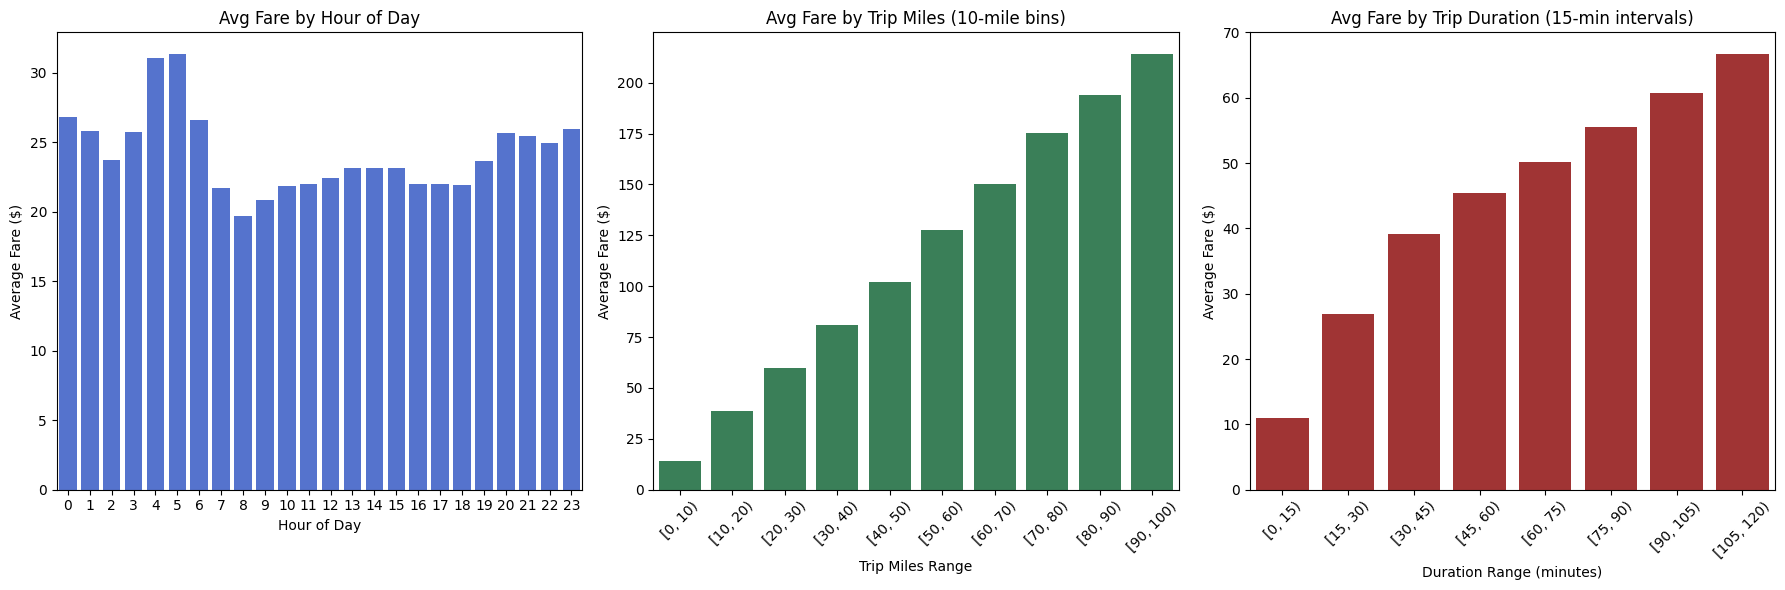

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# 1. Load fare analysis data from Spark output
fare_files = glob.glob('./fare_result/part-*.csv')
fare_df = pd.concat([pd.read_csv(f) for f in fare_files])

# === Convert to numeric (safe casting) ===
fare_df["trip_miles"] = pd.to_numeric(fare_df["trip_miles"], errors='coerce')
fare_df["trip_seconds"] = pd.to_numeric(fare_df["trip_seconds"], errors='coerce')
fare_df["fare"] = pd.to_numeric(fare_df["fare"], errors='coerce')
fare_df["HourOfDay"] = pd.to_numeric(fare_df["HourOfDay"], errors='coerce')

# === Create Binned Columns ===

# 1. Hour of Day (already from 0–23)
hour_avg = fare_df.groupby("HourOfDay", observed=True)["fare"].mean().reset_index()

# 2. Trip Miles (10-mile bins: [0–10), [10–20), ..., [90–100))
fare_df["Miles_Bin"] = pd.cut(fare_df["trip_miles"], bins=range(0, 101, 10), right=False)
miles_avg = fare_df.groupby("Miles_Bin", observed=True)["fare"].mean().reset_index()

# 3. Trip Duration in minutes (15-minute bins)
fare_df["trip_minutes"] = fare_df["trip_seconds"] / 60
fare_df["Duration_Bin"] = pd.cut(fare_df["trip_minutes"], bins=range(0, 121, 15), right=False)
duration_avg = fare_df.groupby("Duration_Bin", observed=True)["fare"].mean().reset_index()

# === Plotting ===
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Avg Fare by Hour
sns.barplot(data=hour_avg, x="HourOfDay", y="fare", ax=axs[0], color="royalblue")
axs[0].set_title("Avg Fare by Hour of Day")
axs[0].set_xlabel("Hour of Day")
axs[0].set_ylabel("Average Fare ($)")

# Plot 2: Avg Fare by Trip Miles
sns.barplot(data=miles_avg, x="Miles_Bin", y="fare", ax=axs[1], color="seagreen")
axs[1].set_title("Avg Fare by Trip Miles (10-mile bins)")
axs[1].set_xlabel("Trip Miles Range")
axs[1].set_ylabel("Average Fare ($)")
axs[1].tick_params(axis='x', rotation=45)

# Plot 3: Avg Fare by Trip Duration
sns.barplot(data=duration_avg, x="Duration_Bin", y="fare", ax=axs[2], color="firebrick")
axs[2].set_title("Avg Fare by Trip Duration (15-min intervals)")
axs[2].set_xlabel("Duration Range (minutes)")
axs[2].set_ylabel("Average Fare ($)")
axs[2].tick_params(axis='x', rotation=45)

# Final layout and save
plt.tight_layout()
plt.savefig("fare_analysis_grouped_bars.png")
plt.show()
